In [ ]:
#@title 1) Setup & install required libraries (run once)
# In Colab some libs exist, but ensure versions and required packages are installed.
!pip install --quiet joblib pulp
# (Flask sometimes not needed in Colab; we simulate API endpoints inside notebook)


In [ ]:
!pip freeze > requirements.txt


In [ ]:
#@title 2) Imports and global settings
import pandas as pd
import numpy as np
import os
import json
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import joblib
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, r2_score
np.random.seed(42)

# show plots inline
%matplotlib inline

# create an output folder in Colab runtime
OUT_DIR = "project_output"
os.makedirs(OUT_DIR, exist_ok=True)
print("Output directory:", OUT_DIR)


Output directory: project_output


In [ ]:
#@title 3) Generate synthetic dataset (parking_history.csv) - run cell
def gen_history(start, hours=24*90):
    rows=[]
    lots = [
        {"lot_id":"A","cap":120,"base":60, "distance":0.2},
        {"lot_id":"B","cap":80, "base":30, "distance":0.6},
        {"lot_id":"C","cap":200,"base":120, "distance":0.4},
    ]
    t = start
    for i in range(hours):
        weekday = t.weekday()
        hour = t.hour
        is_peak = 1 if 8 <= hour <= 18 else 0
        for lot in lots:
            occ = (lot["base"]
                   + (25 if is_peak else -10)
                   + 10*np.sin((hour/24)*2*np.pi)
                   + (10 if weekday>=5 else 0)
                  )
            occ = int(max(0, min(lot["cap"], occ + np.random.normal(0,8))))
            possible = max(0, lot["cap"] - occ)
            bookings = int(max(0, min(possible, np.random.poisson(5 + (occ/lot["cap"])*10))))
            rows.append({
                "timestamp": t.strftime("%Y-%m-%d %H:%M:%S"),
                "lot_id": lot["lot_id"],
                "total_spaces": lot["cap"],
                "occupied": occ,
                "bookings_hour": bookings,
                "weekday": weekday,
                "hour": hour,
                "is_holiday": 0,
                "temperature": round(20 + 5*np.sin((t.timetuple().tm_yday/365)*2*np.pi) + np.random.normal(0,2),1),
                "event_nearby": int(np.random.rand() < 0.05)
            })
        t += timedelta(hours=1)
    return pd.DataFrame(rows)

start = datetime(2025,1,1,0,0,0)
df = gen_history(start, hours=24*90)  # 90 days of hourly data
csv_path = os.path.join(OUT_DIR, "parking_history.csv")
df.to_csv(csv_path, index=False)
# save lots metadata
lots_meta = [
    {"lot_id":"A","total_spaces":120,"distance":0.2},
    {"lot_id":"B","total_spaces":80,"distance":0.6},
    {"lot_id":"C","total_spaces":200,"distance":0.4},
]
with open(os.path.join(OUT_DIR,"lots.json"), "w") as f:
    json.dump(lots_meta, f, indent=2)

print("Created:", csv_path)
df.head()


Created: project_output/parking_history.csv


,timestamp,lot_id,total_spaces,occupied,bookings_hour,weekday,hour,is_holiday,temperature,event_nearby
0,2025-01-01 00:00:00,A,120,53,8,2,0,0,19.8,0
1,2025-01-01 00:00:00,B,80,16,5,2,0,0,21.2,0
2,2025-01-01 00:00:00,C,200,106,9,2,0,0,18.6,0
3,2025-01-01 01:00:00,A,120,53,8,2,1,0,17.2,0
4,2025-01-01 01:00:00,B,80,17,4,2,1,0,23.8,0


Rows: 6480
       bookings_hour              occupied
                mean       std        mean
lot_id                                    
A          10.648611  3.571949   68.638889
B           9.189352  3.746331   38.441204
C          11.391667  3.455443  128.192593


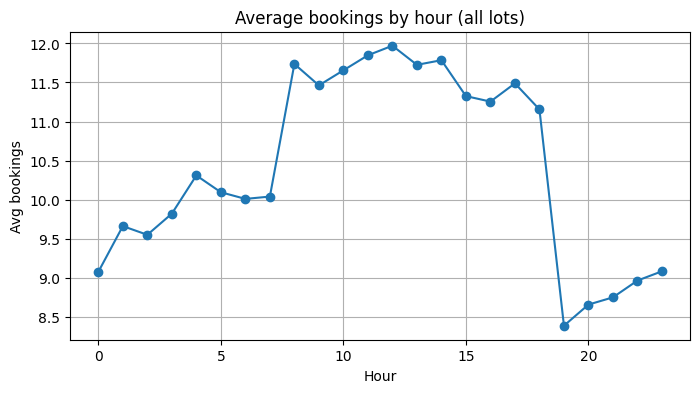

In [ ]:
#@title 4) Exploratory checks: basic stats & plots
df = pd.read_csv(csv_path, parse_dates=["timestamp"])
print("Rows:", len(df))
print(df.groupby("lot_id").agg({"bookings_hour":["mean","std"], "occupied":["mean"]}))

# plot hourly bookings average by hour of day (combined)
hour_stats = df.groupby("hour")["bookings_hour"].mean()
plt.figure(figsize=(8,4))
plt.plot(hour_stats.index, hour_stats.values, marker='o')
plt.title("Average bookings by hour (all lots)")
plt.xlabel("Hour")
plt.ylabel("Avg bookings")
plt.grid(True)
plt.show()


In [ ]:
#@title 5) Train demand prediction model (RandomForest)
# Feature engineering and training
df = pd.read_csv(csv_path, parse_dates=["timestamp"])
# ensure hour, weekday exist
df["hour"] = df["hour"]
df["dayofweek"] = df["weekday"]

features = ["lot_id","total_spaces","occupied","hour","dayofweek","is_holiday","temperature","event_nearby"]
X = pd.get_dummies(df[features], columns=["lot_id"], prefix="lot_id")
y = df["bookings_hour"]

# train/test split (random shuffle)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=True)

print("Train shape:", X_train.shape, "Test shape:", X_test.shape)

model = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
model.fit(X_train, y_train)

pred = model.predict(X_test)
mae = mean_absolute_error(y_test, pred)
r2 = r2_score(y_test, pred)
print(f"MAE: {mae:.3f}   R2: {r2:.3f}")

# Save model + columns
model_path = os.path.join(OUT_DIR, "booking_model.pkl")
joblib.dump({"model":model, "columns": X.columns.tolist()}, model_path)
print("Saved model to", model_path)


Train shape: (5184, 10) Test shape: (1296, 10)
MAE: 2.717   R2: 0.144
Saved model to project_output/booking_model.pkl


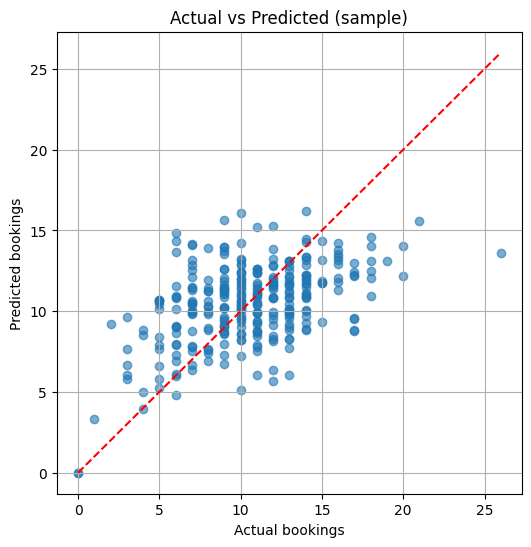

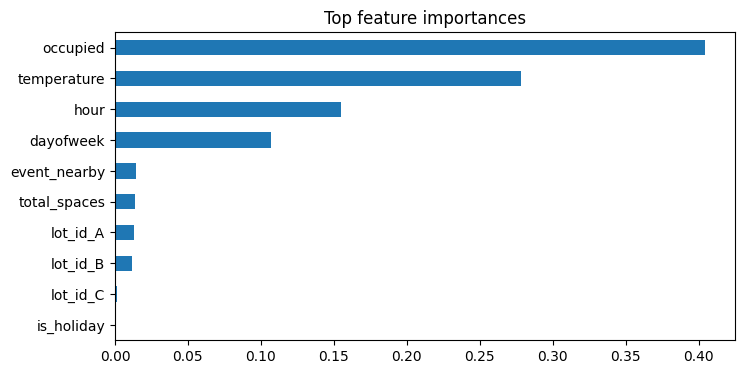

In [ ]:
#@title 6) Evaluate model: scatter + feature importance
# scatter actual vs predicted (sample)
nsample = 300
idx = np.random.choice(len(y_test), size=nsample, replace=False)
plt.figure(figsize=(6,6))
plt.scatter(y_test.values[idx], pred[idx], alpha=0.6)
plt.plot([0, max(y_test.max(), pred.max())], [0, max(y_test.max(), pred.max())], 'r--')
plt.xlabel("Actual bookings")
plt.ylabel("Predicted bookings")
plt.title("Actual vs Predicted (sample)")
plt.grid(True)
plt.show()

# feature importance
fi = pd.Series(model.feature_importances_, index=X.columns).sort_values(ascending=False).head(20)
plt.figure(figsize=(8,4))
fi.plot.barh()
plt.gca().invert_yaxis()
plt.title("Top feature importances")
plt.show()


In [ ]:
#@title 7) Allocation optimizer (pulp if available, else greedy fallback)
import math
try:
    import pulp
    PULP_AVAILABLE = True
except Exception:
    PULP_AVAILABLE = False

def allocate_requests(lots, total_requests):
    """
    lots: dict {lot_id: {"capacity":int, "occupied":int, "distance":float}}
    total_requests: int
    returns allocation dict {lot_id: assigned}
    """
    available = {k: max(0, v["capacity"] - v.get("occupied", 0)) for k,v in lots.items()}
    if PULP_AVAILABLE:
        prob = pulp.LpProblem("alloc", pulp.LpMinimize)
        x = {i: pulp.LpVariable(f"x_{i}", lowBound=0, cat="Integer") for i in lots}
        prob += pulp.lpSum([lots[i]["distance"] * x[i] for i in lots])
        for i in lots:
            prob += x[i] <= available[i]
        prob += pulp.lpSum([x[i] for i in lots]) == total_requests
        prob.solve(pulp.PULP_CBC_CMD(msg=False))
        return {i: int(pulp.value(x[i])) for i in lots}
    else:
        # greedy by distance (nearest first)
        alloc = {k:0 for k in lots}
        left = total_requests
        for k in sorted(lots.keys(), key=lambda k: lots[k]["distance"]):
            take = min(available[k], left)
            alloc[k] = take
            left -= take
            if left <= 0:
                break
        # if left remains, distribute as much as possible
        return alloc

# Example usage:
lots = {"A":{"capacity":120,"occupied":70,"distance":0.2},
        "B":{"capacity":80,"occupied":50,"distance":0.6},
        "C":{"capacity":200,"occupied":130,"distance":0.4}}
print("Alloc example for 25 incoming requests:", allocate_requests(lots, 25))
print("PULP available:", PULP_AVAILABLE)


Alloc example for 25 incoming requests: {'A': 25, 'B': 0, 'C': 0}
PULP available: True


In [ ]:
#@title 8) Simple booking simulator using SQLite (store bookings & check availability)
import sqlite3, time
DB = os.path.join(OUT_DIR, "parking.db")

def init_db(db_path=DB, lots_meta=lots_meta):
    conn = sqlite3.connect(db_path)
    cur = conn.cursor()
    cur.execute("""
    CREATE TABLE IF NOT EXISTS lots (
        lot_id TEXT PRIMARY KEY,
        total_spaces INTEGER,
        distance REAL
    )""")
    cur.execute("""
    CREATE TABLE IF NOT EXISTS bookings (
        id INTEGER PRIMARY KEY AUTOINCREMENT,
        lot_id TEXT,
        slot TEXT,
        user_id TEXT,
        status TEXT,
        created_at TEXT DEFAULT CURRENT_TIMESTAMP
    )""")
    conn.commit()
    for l in lots_meta:
        cur.execute("INSERT OR REPLACE INTO lots (lot_id, total_spaces, distance) VALUES (?,?,?)",
                    (l["lot_id"], l["total_spaces"], l["distance"]))
    conn.commit()
    conn.close()
    print("DB initialized:", db_path)

def check_availability(lot_id, slot):
    conn = sqlite3.connect(DB)
    conn.row_factory = sqlite3.Row
    cur = conn.cursor()
    cur.execute("SELECT total_spaces FROM lots WHERE lot_id=?", (lot_id,))
    r = cur.fetchone()
    if not r:
        conn.close()
        return {"error":"unknown lot"}
    cap = r["total_spaces"]
    cur.execute("SELECT COUNT(*) as cnt FROM bookings WHERE lot_id=? AND slot=? AND status='confirmed'", (lot_id, slot))
    booked = cur.fetchone()[0]
    conn.close()
    return {"lot_id":lot_id,"slot":slot,"total_spaces":cap,"booked":booked,"available":max(0, cap-booked)}

def book_slot(lot_id, slot, user_id="anonymous"):
    av = check_availability(lot_id, slot)
    if "error" in av: return {"status":"error","message":av["error"]}
    if av["available"] <= 0:
        return {"status":"failed","reason":"no availability"}
    conn = sqlite3.connect(DB)
    cur = conn.cursor()
    cur.execute("INSERT INTO bookings (lot_id, slot, user_id, status) VALUES (?,?,?,'confirmed')", (lot_id, slot, user_id))
    conn.commit()
    bid = cur.lastrowid
    conn.close()
    return {"status":"success","booking_id":bid,"lot_id":lot_id,"slot":slot}

# init database
init_db()

# test booking simulation
slot_example = "2025-09-15 09:00:00"
print("Availability before booking:", check_availability("A", slot_example))
print("Make booking #1:", book_slot("A", slot_example, user_id="user_alice"))
print("Availability after booking #1:", check_availability("A", slot_example))


DB initialized: project_output/parking.db
Availability before booking: {'lot_id': 'A', 'slot': '2025-09-15 09:00:00', 'total_spaces': 120, 'booked': 1, 'available': 119}
Make booking #1: {'status': 'success', 'booking_id': 2, 'lot_id': 'A', 'slot': '2025-09-15 09:00:00'}
Availability after booking #1: {'lot_id': 'A', 'slot': '2025-09-15 09:00:00', 'total_spaces': 120, 'booked': 2, 'available': 118}


In [ ]:
#@title 9) Predict function (load saved model and predict bookings for a lot & time)
# This is what a /predict endpoint would do
model_data = joblib.load(model_path)
loaded_model = model_data["model"]
model_columns = model_data["columns"]

def make_features_payload(payload):
    # payload: {lot_id, total_spaces, occupied, timestamp, is_holiday, temperature, event_nearby}
    ts = pd.to_datetime(payload.get("timestamp", datetime.now()))
    hour = ts.hour
    dayofweek = ts.weekday()
    total_spaces = int(payload.get("total_spaces", payload.get("capacity", 100)))
    occupied = int(payload.get("occupied", max(0, int(total_spaces*0.5))))
    base = {
        "total_spaces": total_spaces,
        "occupied": occupied,
        "hour": hour,
        "dayofweek": dayofweek,
        "is_holiday": int(payload.get("is_holiday",0)),
        "temperature": float(payload.get("temperature",22.0)),
        "event_nearby": int(payload.get("event_nearby",0))
    }
    df_ = pd.DataFrame([base])
    # add lot one-hot cols
    for c in model_columns:
        if c.startswith("lot_id_"):
            df_[c] = 1 if c == f"lot_id_{payload['lot_id']}" else 0
    df_ = df_.reindex(columns=model_columns, fill_value=0)
    return df_

# example prediction
payload = {"lot_id":"A","total_spaces":120,"occupied":70,"timestamp":"2025-09-15 09:00:00"}
Xp = make_features_payload(payload)
pred_val = loaded_model.predict(Xp)[0]
print("Predicted bookings (raw):", pred_val, " -> rounded:", int(round(max(0,pred_val))))


Predicted bookings (raw): 10.25  -> rounded: 10


In [ ]:
#@title 10) Save artifacts and create downloadable zip
import zipfile
zipname = os.path.join(OUT_DIR, "online_parking_project.zip")
with zipfile.ZipFile(zipname, "w") as z:
    z.write(csv_path, arcname="parking_history.csv")
    z.write(model_path, arcname="booking_model.pkl")
    z.write(os.path.join(OUT_DIR,"lots.json"), arcname="lots.json")
    z.write(DB, arcname="parking.db")
print("Created ZIP:", zipname)


Created ZIP: project_output/online_parking_project.zip
